In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools


import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

# <center>Deep Generative Models</center>
## <center>Seminar 2</center>

<center><img src="pics/AIMastersLogo.png" width=600 /></center>
<center>19.09.2022</center>


### Petr Mokrov


tg: https://t.me/PVMokrov

e-mail: mokrov.pv@phystech.edu

## Plan

- Autoregressive models. MADE
- Masked Linear Layer
- MADE implementation
- CharCNN hints

### The distribution we will work with

In [5]:
def generate_2d_data(count, bins, height_coefficient=1.0):
    h_bins = int(bins * height_coefficient)
    w_bins = int(bins)
    # Загружаем картинку, сжимаем к размеру (w_bins x h_bins),
    # конвертируем к grayscale - формату
    im = Image.open('pics/2d_distribution.png').resize((w_bins, h_bins)).convert('L')
    im = np.array(im).astype('float32')
    # Сейчас im : np.array размера (64, 64), 
    # элементы этого массива выглядят так:
    # 
    # array([[12., 12., 13., ...,  6.,  6.,  4.],
    #        [11., 13., 15., ...,  7.,  6.,  6.],
    #        [14., 16., 18., ...,  7.,  7.,  6.],
    #        ...,
    #        [24., 21., 25., ..., 31., 31., 24.],
    #        [18., 21., 21., ..., 26., 26., 23.],
    #        [17., 18., 20., ..., 28., 21., 19.]], dtype=float32)

    # Здесь мы получаем двумерное категориальное распределение, 
    # с числом параметров 64 * 64
    # КОТОРОЕ МЫ И ХОТИМ ПРИБЛИЗИТЬ НАШЕЙ МОДЕЛЬЮ
    dist = im / im.sum()

    # pairs перечисляет все возможные пиксели
    # pairs = [(0, 0), (0, 1), ... (h_bins-1, w_bins-2), (h_bins-1, w_bins-1)]
    pairs = list(itertools.product(range(h_bins), range(w_bins)))
    # выбираем count пикселей в соответствии с вероятностями из dist
    idxs = np.random.choice(len(pairs), size=count, replace=True, p=dist.reshape(-1))
    samples = np.array([pairs[i] for i in idxs])

    split = int(0.8 * len(samples))
    return dist, samples[:split], samples[split:]

In [6]:
def plot_2d_data(train_data, test_data, bins, height_coefficient=1.0):
    h_bins = int(bins * height_coefficient)
    w_bins = int(bins)
    train_dist, test_dist = np.zeros((h_bins, w_bins)), np.zeros((h_bins, w_bins))
    for i in range(len(train_data)):
        train_dist[train_data[i][0], train_data[i][1]] += 1
    train_dist /= train_dist.sum()

    for i in range(len(test_data)):
        test_dist[test_data[i][0], test_data[i][1]] += 1
    test_dist /= test_dist.sum()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    ax1.set_title('Train Data')
    ax1.imshow(train_dist, cmap='gray')
    ax1.axis('off')
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x0')

    ax2.set_title('Test Data')
    ax2.imshow(test_dist, cmap='gray')
    ax2.axis('off')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x0')

    plt.show()

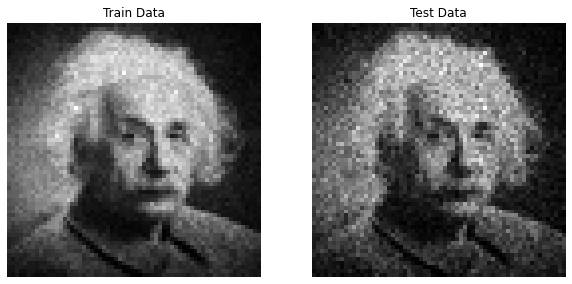

In [7]:
COUNT = 500000
BINS = 64

image, train_data, test_data = generate_2d_data(COUNT, BINS)
plot_2d_data(train_data, test_data, BINS)

## Autoregressive models

Let $\boldsymbol{x} \sim p(\boldsymbol{x} | \theta) \, , \, \boldsymbol{x} \in \mathbf{R}^d$

**Likelihood factorization**: $\log p(\boldsymbol{x} | \theta) = \sum\limits_{j = 1}^d \log p\left( x_i | \boldsymbol{x}_{1:j-1} , \theta\right)$

**Sampling procedure**:

* Sample $\hat{x}_1 \sim p(x_1 | \theta)$

* Sample $\hat{x}_2 \sim p(x_2 | \hat{x}_1 \theta)$

* ...

* Sample $\hat{x}_d \sim p(x_d | \hat{\boldsymbol{x}}_{1:d-1} , \theta)$


## Autoregressive models

**Question.** How to impose autoregressive properties in a simple autoencoder model?

<center><img src="pics/autoencoder.png" width=300/></center>

## MADE

Original article: [link](https://arxiv.org/pdf/1502.03509.pdf)

<img src="pics/made.png" width=800 height=600 />

**Masks generation procedure**

* Define the ordering of input elements from $1$ to $d$

* Assign a random number $k$ from $1$ to $d - 1$ to each hidden unit. The number $k$ gives the maximum number of input units to which the unit under consideration can be connected.

* *(For hidden layer)* Connect each hidden unit with number $k$ with the previous layer units which have the number **less or equal** than $k$

* *(For output layer)* Connect each output unit with number $k$ with the previous layer units which have the number **less** than $k$

**Question.** How to implement the masking of linear layers?

In [8]:
class MaskedLinear(torch.nn.Linear):
    
    
    def __init__(self, in_features, out_features):
        super().__init__(in_features, out_features)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input):
         
        return torch.nn.functional.linear(input, self.mask * self.weight, self.bias)

**Question** Why do we need `register_buffer` function? What is the difference between `register_buffer` and `register_parameter`?

In [9]:
ml = MaskedLinear(10, 10)
print("state dict keys: ", ml.state_dict().keys())
print("number of state dict elems: ", len(ml.state_dict()))
n_params = 0
for _ in ml.parameters():
    n_params += 1
print("number of params: ", n_params)

state dict keys:  odict_keys(['weight', 'bias', 'mask'])
number of state dict elems:  3
number of params:  2


## MADE

<img src="pics/made.png" width=800 height=600 />

**Question 1.** What is model's input and output? Consider 2 cases:
* binarized MNIST
* 2D "image" categorical distribution

**Question 2.** What loss fuction should we optimize (Consider both cases)? How?

**Question 3.** Tensors' shapes?

### MADE implementation and application

#### Problem statement

We have 2D distribution, each component $j$ sampled from $\text{Categorical}(\theta_1^j, \dots, \theta_{64}^j)$

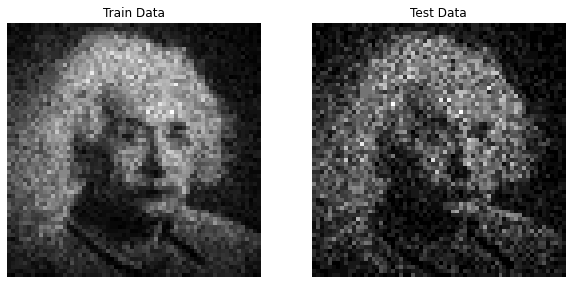

In [10]:
COUNT = 100000
BINS = 64

image, train_data, test_data = generate_2d_data(COUNT, BINS)
plot_2d_data(train_data, test_data, BINS)

#### Libraries

In [11]:
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import make_grid

#### MADE implementation

In [12]:
def to_one_hot(labels, d):
    assert len(labels.shape) == 2
    one_hot = F.one_hot(labels.to(torch.int64), d).float()
    return one_hot.view((labels.shape[0], -1)).float()

In [13]:
class MADE(torch.nn.Module):
    
    def __init__(self, nin, bins, hidden_sizes):
        '''
        :Parameters:
        nin : int : number of input dimensions
        bins : int : categorical bins in each input dimension
        hidden_sizes : list : sizes of hidden layers
        '''
        super().__init__()
        
        
        self.nin = nin # 2
        self.nout = nin * bins # 128
        self.bins = bins # 64
        
        self.hidden_sizes = hidden_sizes
        # we will use the trivial ordering of input units
        self.ordering = np.arange(self.nin)
        
        
        self.net = []
        hs = [self.nin * bins] + self.hidden_sizes + [self.nout]
        for h0, h1 in zip(hs[:-2], hs[1:-1]):
            self.net.extend([
                MaskedLinear(h0, h1),
                torch.nn.ReLU(),
            ])
            
        
        self.net.append(MaskedLinear(hs[-2], hs[-1]))
        self.net = torch.nn.Sequential(*self.net)

        self.create_mask()  # builds the initial self.m connectivity


    def create_mask(self):
        
        # 1) The ordering of input units from 1 to d (self.ordering).
        # 2) Assign the random number k from 1 to d − 1 to each hidden unit. 
        #    This number gives the maximum number of input units to which the unit can be connected.
        # 3) Each hidden unit with number k is connected with the previous layer units 
        #   which has the number less or equal than k.
        # 4) Each output unit with number k is connected with the previous layer units 
        #    which has the number less than k.

        self.assigned_numbers = {}
        self.masks = []
        L = len(self.hidden_sizes)
        
        # sample the order of the inputs and the connectivity of all neurons
        self.assigned_numbers[-1] = self.ordering
        for l in range(L):
            self.assigned_numbers[l] = np.random.randint(self.assigned_numbers[l - 1].min(), 
                                      self.nin - 1, size=self.hidden_sizes[l])
            
            
        # construct the mask matrices
        masks = [self.assigned_numbers[l - 1][:, None] <= self.assigned_numbers[l][None, :] for l in range(L)]
        masks.append(self.assigned_numbers[L - 1][:, None] < self.assigned_numbers[-1][None, :])

        masks[-1] = np.repeat(masks[-1], self.bins, axis=1)  
        masks[0] = np.repeat(masks[0], self.bins, axis=0)
        
        self.masks = masks 
       

        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l, m in zip(layers, masks):
            l.set_mask(m)

    
    def visualize_masks(self):
        prod = self.masks[0]
        for idx, m in enumerate(self.masks):
            plt.figure(figsize=(3, 3))
            plt.title(f'layer: {idx}')
            plt.imshow(m.T, vmin=0, vmax=1, cmap='gray')
            plt.show()

            if idx > 0:
                prod=prod.dot(m)

        plt.figure(figsize=(3, 3))
        plt.title('prod')
        plt.imshow(prod.T, vmin=0, vmax=1, cmap='gray')
        plt.show()

    
    def forward(self, x):
        
        """
        :Parameters:
        x: torch.Size([BS,2]) : input sample
        :Output:
        out : torch.Size([BS, bins, 2]) : output 
        """
        
        assert len(x.size()) == 2
        assert x.shape[1] == self.nin
        batch_size = x.shape[0]
     
        # 1) apply one hot encoding to x
        # 2) apply the model
        # 3) reshape and transpose the output to (batch_size, self.bins, self.nin)
        
        x = to_one_hot(x, self.bins) 
        # torch.tensor([B,128])
        
        logits = self.net(x)
        # torch.tensor ([B,128])
        
        logits = logits.view(batch_size, self.nin, self.bins)
        # torch.tensor([B,2,64])
        
        return logits.permute(0, 2, 1)

    
    def sample(self, n, device='cpu'):
        """
        :Parameters:
        n: int: number of samples
        :Output:
        out: torch.Size([n, nin])
        """
        # read carefully and understand the sampling process
        xs = []
        for _ in range(n):
            # [BS = 1, nin]
            x = torch.randint(0, self.bins, (1, self.nin)).to(device)
          
            for it in self.ordering:
                # logits: [BS = 1, bins, nin]
                logits = model(x)
                
                # probs: [nin, bins]
                probs = torch.nn.functional.softmax(logits.squeeze(0), dim=0).T
                
                # build the distribution 
                # p(\hat{x}_{ordering[i + 1]}| \hat{x}_{ordering[:i + 1]}, \theta)
                distr = torch.distributions.categorical.Categorical(probs[it])
                
                # sample \hat{x}_{ordering[i + 1]}
                x[0, it] = distr.sample()
            xs.append(x)
        xs = torch.cat(xs)
        return xs.cpu().numpy()

#### Loss function

In [14]:
def get_cross_entropy_loss(model, x):
    return F.cross_entropy(model(x), x.long())


Discretization of the learned distribution on the grid

In [15]:
def get_distribution(model, device='cpu'):
    # x: [bins**2, 2]
    x = np.mgrid[0:model.bins, 0:model.bins].reshape(2, model.bins ** 2).T
    x = torch.LongTensor(x)
    x = x.to(device)  
    # log_probs: [bins**2, bins, 2]
    log_probs = F.log_softmax(model(x), dim=1)
    # distribution: [bins**2, 2]
    distribution = torch.gather(log_probs, 1, x.unsqueeze(1)).squeeze(1)
    distribution = distribution.sum(dim=1)
    return distribution.exp().view(model.bins, model.bins).detach().cpu().numpy()

#### Training utilities

**Question.** What do `model.train()` and `model.eval()` modes actually mean?

In [16]:
def train_epoch(model, train_loader, optimizer, device='cpu'):
    model.train()
  
    train_losses = []
    for x in train_loader:
        x = x.to(device)
        loss = get_cross_entropy_loss(model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses


def eval_model(model, data_loader, device='cpu'):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)
            loss = get_cross_entropy_loss(model, x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()


def train_model(model, train_loader, test_loader, epochs, lr, device='cpu'):
#     model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_model(model, test_loader, device=device)]
    for epoch in range(epochs):
        model.train()
        train_losses.extend(train_epoch(model, train_loader, optimizer, device=device))
        test_loss = eval_model(model, test_loader, device=device)
        test_losses.append(test_loss)

    return train_losses, test_losses

def plot_training_curves(train_losses, test_losses):
    plt.figure(figsize=(8, 6))
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title('training curves')
    plt.xlabel('Epoch')
    plt.ylabel('NLL')

def plot_2d_distribution(true_dist, learned_dist):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    ax1.imshow(true_dist, cmap='gray')
    ax1.set_title('True Distribution')
    ax1.axis('off')
    ax2.imshow(learned_dist, cmap='gray')
    ax2.set_title('Learned Distribution')
    ax2.axis('off')

**Question.** How to reduce `cuda` or `cpu` memory usage given the `batch_size` is fixed? Do we need `retain_graph=True` parameter in `loss.backward(...)` method?

#### Hyperparameters

In [39]:
HIDDEN_SIZES = [100, 100, 100]
device = 'cuda:3'

#### Model creation

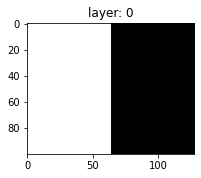

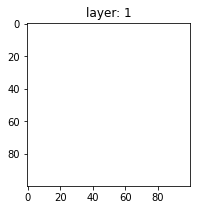

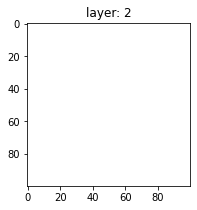

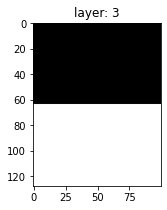

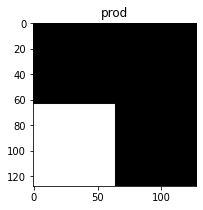

In [40]:
HIDDEN_SIZES = [100, 100, 100]

np.random.seed(36)
model = MADE(2, BINS, HIDDEN_SIZES).to(device)
model.visualize_masks()

#### Training launch

In [41]:
# you have to choose these parameters by yourself
BATCH_SIZE = 256
EPOCHS = 20
LR = 0.01

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR, device=device)

# assert test_losses[-1] < 4.0

#### Results

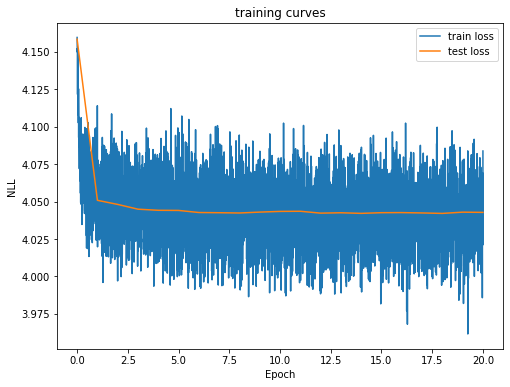

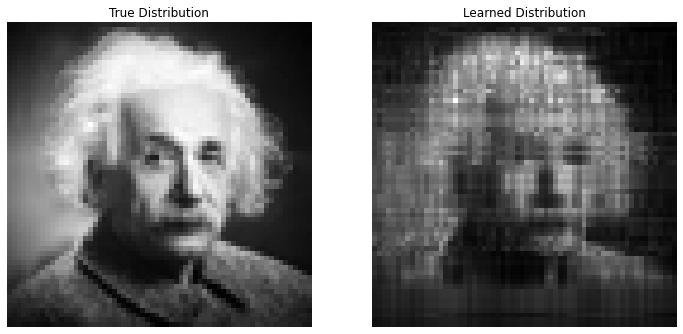

In [42]:
distribution = get_distribution(model, device)
# assert distribution.shape == (BINS, BINS)

plot_training_curves(train_losses, test_losses)
plot_2d_distribution(image, distribution)

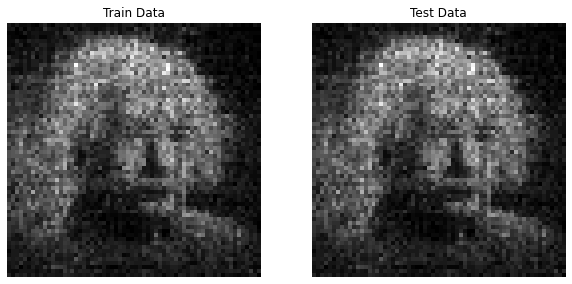

In [43]:
model_sample = model.sample(50000, device)
plot_2d_data(model_sample, model_sample, BINS)

## Pixel CNN

the original article: [link](https://arxiv.org/pdf/1601.06759.pdf)

### Autoregressive models for binarized images

Let $\boldsymbol{x} \sim p(\boldsymbol{x} | \theta) \, , \, \boldsymbol{x} \in \mathbf{R}^{n \times n}$

**Likelihood factorization**: $\log p(\boldsymbol{x} | \theta) = \sum\limits_{j = 1}^{n \times n} \log p\left( x_i | \boldsymbol{x}_{1:j-1} , \theta\right)$

**Sampling procedure**:

* Sample $\hat{x}_1 \sim p(x_1 | \theta)$

* Sample $\hat{x}_2 \sim p(x_2 | \hat{x}_1 \theta)$

* ...

* Sample $\hat{x}_{n^2} \sim p(x_{n^2} | \hat{\boldsymbol{x}}_{1:n^2-1} , \theta)$

#### Ordering

<center><img src="pics/pixelCNN_ordering.png" width=400 /></center>

#### Masked convolutions

* Masked convolution of **type A**:

<center><img src="pics/pixelCNN_convolution.png" width=600 /></center>

* Masked convolution of **type B** allows self-conditioning

**Question 1.**: Where can we apply convolutions of **type B** to preserve autoregressive property?

**Question 2.**: In your homework you will be asked to train CharCNN model on binarized MNIST dataset. 

* Input tensor shapes?

* Output tensor shapes? Loss function?

### PixelCNN implementation details

* **PixelCNN** is fully convolutional NN, which applies masked convolution of **type A** to the input layer and convolutions of **type B** to the hidden layers. 

* It preserves spacial dimensions of a processed tensor

**Question 1.** How to preserve spatial dimensionality of a processed tensor?

**Question 2.** How to sample from the trained model?

### PixelCNN for RGB images

$p\left(x_i | \boldsymbol{x}_{1:i-1}, \theta \right) = p\left(x_{i, R} | \boldsymbol{x}_{1:i-1}, \theta \right) p\left(x_{i, G} | x_{i, R}, \boldsymbol{x}_{1:i-1}, \theta\right) p\left(x_{i, B} | x_{i, R}, x_{i, G}, \boldsymbol{x}_{1:i-1}, \theta\right)$

<center><img src="pics/pixelCNN_RGB.png" width=500 /></center>

**Question 1.** Input and output tensor shapes? Loss function?

**Question 2.** How to preserve `RGB` structure through the convolutions? How do convolutions look like?

## Bayesian framework